In [1]:
import numpy
import jax
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap

mred = u'#d62728' 
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 

## Delay time distribution (DTD) Eq. 6 of https://academic.oup.com/mnras/article/506/3/3330/6318383?login=false

In [2]:
@jjit
## tau    (Gyr)
## tp      (Gyr)
## A   (1e-13 M^{-1}_{sun} yr^{-1}
##
##  Nominal values A=2.11; beta=-1.13; tp=0.04

def DTD(tau, A, beta, tp):
    return jax.lax.cond(tau < tp, lambda a: 0., lambda a : a[0]*jnp.power(a[1],a[2]), [A, tau, beta])

In [3]:
DTD_vmap = jjit(vmap(DTD, in_axes=(0, None, None, None)))

In [4]:
A=2.11; beta=-1.13; tp=0.04

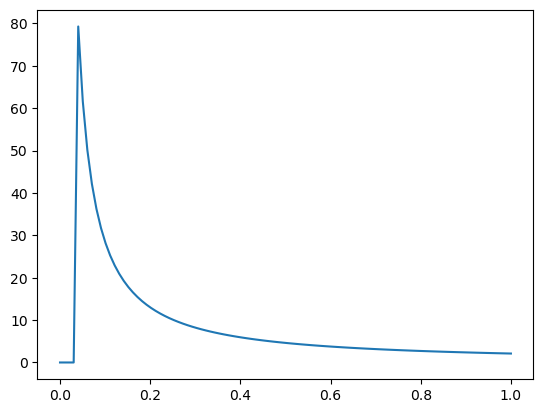

In [5]:
tau = jnp.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(tau, DTD_vmap(tau, A, beta, tp))

## Placeholder Main Sequence of Star Formation with stupid t-z relation Eq. 8 of  https://academic.oup.com/mnras/article/506/3/3330/6318383?login=false

In [6]:
@jjit
## M    (1e10)
## t Gyr
def SFH(t, M):
    d = t * 1e9 * 3.16e7 * 3e8 /3.09e16/1e6 # Mpc
    z= 68.*d/3e5
    return jnp.power(M,0.7)*(jnp.exp(1.9*z)/(jnp.exp(1.7*(z-2))+jnp.exp(0.2*(z-2))))

In [7]:
SFH_vmap = jjit(vmap(SFH, in_axes=(0, None)))

In [8]:
M=1.

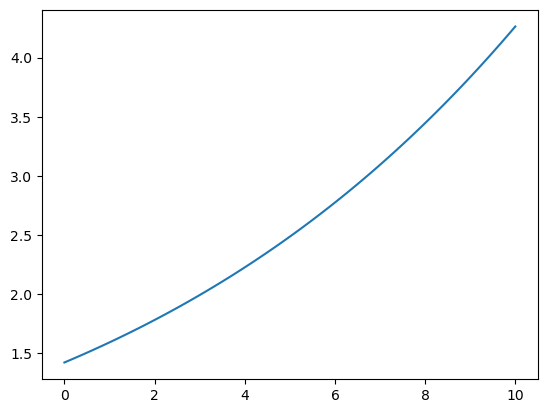

In [9]:
t = jnp.linspace(0, 10, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t, SFH_vmap(t, M))

## DIFFSTAR SFH
Use an example galaxy that has been parameterized by DIFFSTAR

In [10]:
from diffmah.monte_carlo_halo_population import mc_halo_population

T0 = 13.8
tarr = numpy.linspace(0.1, T0, 200)

logmhpop = numpy.zeros(500) + 12.0
halopop = mc_halo_population(tarr, T0, logmhpop)

# Collect mah_params into array of shape (n_halos, 4)
mah_params_pop = numpy.array((halopop.log_mah[:, -1], halopop.lgtc, halopop.early_index, halopop.late_index)).T

In [11]:
from mspop import mc_galhalo_ms_lgmpop
from jax import random as jran
ran_key = jran.PRNGKey(0)
ms_u_params_pop, ms_sfh_pop, ms_logsmh_pop = mc_galhalo_ms_lgmpop(ran_key, mah_params_pop, tarr)

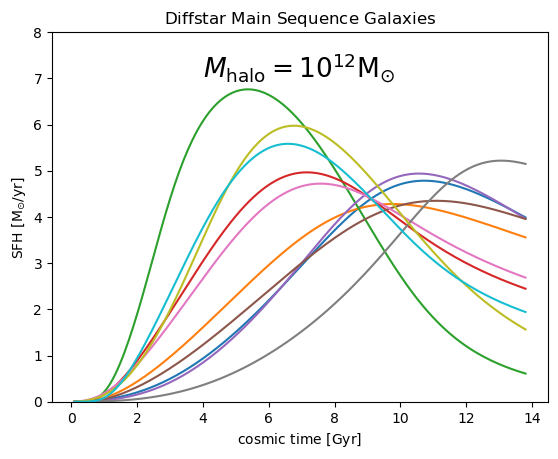

In [12]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 8)
for iplot in range(0, 10):
    ih = numpy.random.randint(0, ms_sfh_pop.shape[0])
    __=ax.plot(tarr, ms_sfh_pop[ih, :])
    
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SFH\ [M_{\odot}/yr]}$')

a, b = 4, 7
__=ax.annotate(r'$M_{\rm halo}=10^{12}{\rm M_{\odot}}$', xy=(a, b), xytext=(a, b), size=19)

## Supernova Rate

### Real SFH

In [22]:
@jjit
def SNR_DS(t0, M, A, beta, tp,ran_key, mah_params_pop):
    logtf=jnp.log(15.)
    logtaus = jnp.linspace(jnp.log(t0), logtf, 1000)
    taus = jnp.exp(logtaus)
    _, ms_sfh_pop, _ = mc_galhalo_ms_lgmpop(ran_key, mah_params_pop, taus)
    kernel = DTD_vmap(taus-t0, A, beta, tp) * ms_sfh_pop[250,:] * taus
    return jnp.trapz(kernel,logtaus)

In [23]:
SNR_DS_vmap  = jjit(vmap(SNR_DS,  in_axes=(0, None, None, None, None, None, None)))

In [27]:
t0=jnp.linspace(0.1, 13.8, 50)

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0, SNR_DS_vmap(t0, M, A, beta, tp,ran_key, mah_params_pop))

In [26]:
ms_sfh_pop.shape

(500, 200)

### Dummy SFH

In [ ]:
@jjit
# in log(tau) units
def SNR_kernel(logtau, t0, M, A, beta, tp):
    tau = jnp.exp(logtau)
    return DTD(tau-t0, A, beta, tp)*SFH(tau, M)*tau

In [ ]:
SNR_kernel_vmap = jjit(vmap(SNR_kernel, in_axes=(0, None, None, None, None, None)))

In [ ]:
@jjit
def SNR(t0, M, A, beta, tp):
    logtf=jnp.log(12.)
    logtaus = jnp.linspace(jnp.log(t0), logtf, 1000)
    kernel = SNR_kernel_vmap(logtaus, t0, M, A, beta, tp)
    return jnp.trapz(kernel,logtaus)

In [ ]:
SNR_vmap = jjit(vmap(SNR, in_axes=(0, None, None, None, None)))